# infoGAN in Keras

*@masahiro rikiso, 170213*

* arxiv: https://arxiv.org/abs/1606.03657
* implementation reference:
https://github.com/tdeboissiere/DeepLearningImplementations/tree/master/InfoGAN
* nice blog: http://www.inference.vc/infogan-variational-bound-on-mutual-information-twice/

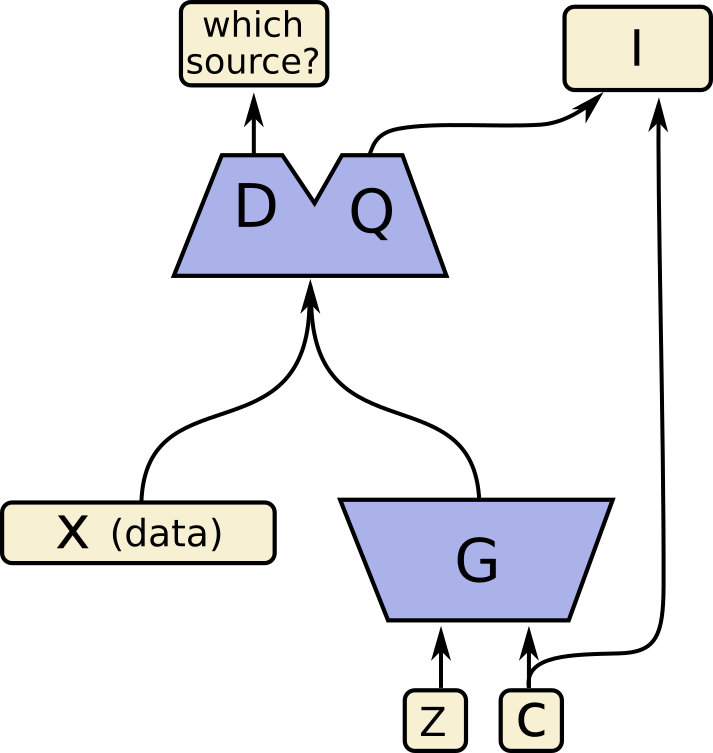

In [2]:
from IPython.display import Image
Image("https://pbs.twimg.com/media/ClBVpr0UoAIdJV5.png", width=250)

## load dataset

In [3]:
from keras.datasets import mnist

Using TensorFlow backend.


In [4]:
(X_train, _), _ = mnist.load_data()

In [5]:
X_train = X_train.reshape(60000,28,28,1)

## define NN architecture

In [6]:
import numpy as np

from keras.optimizers import Adam
from keras.models import Model
from keras.layers.core import Flatten, Dense, Dropout, Activation, Lambda, Reshape
from keras.layers.convolutional import Convolution2D, UpSampling2D
from keras.layers import Input, merge
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.utils import generic_utils
import keras.backend as K

In [7]:
def generator_upsampling(cat_dim, cont_dim, noise_dim):
    cat_input = Input(shape=cat_dim, name="cat_input")
    cont_input = Input(shape=cont_dim, name="cont_input")
    noise_input = Input(shape=noise_dim, name="noise_input")

    gen_input = merge([cat_input, cont_input, noise_input], mode="concat")

    x = Dense(1024)(gen_input)
    x = BatchNormalization(mode=1)(x)
    x = Activation("relu")(x)

    x = Dense(7*7*128)(x)
    x = BatchNormalization(mode=1)(x)
    x = Activation("relu")(x)

    x = Reshape((7,7,128))(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Convolution2D(64, 3, 3, border_mode="same")(x)
    x = BatchNormalization(mode=2, axis=-1)(x)
    x = Activation("relu")(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Convolution2D(32, 3, 3, border_mode="same")(x)
    x = BatchNormalization(mode=2, axis=-1)(x)
    x = Activation("relu")(x)

    x = Convolution2D(1, 3, 3, name="gen_convolution2d_final", border_mode="same", activation='tanh')(x)

    generator_model = Model(input=[cat_input, cont_input, noise_input], output=[x], name="generator_upsampling")
    
    return generator_model

In [8]:
def discriminator(cat_dim, cont_dim):
    disc_input = Input(shape=(28,28,1), name="discriminator_input")

    x = Convolution2D(64, 3, 3, subsample=(2, 2), name="disc_convolution2d_1", border_mode="same")(disc_input)
    x = LeakyReLU(0.2)(x)

    x = Convolution2D(128, 3, 3, subsample=(2, 2), name="disc_convolution2d_2", border_mode="same")(x)
    x = BatchNormalization(mode=2, axis=-1)(x)
    x = LeakyReLU(0.2)(x)

    x = Flatten()(x)
    x = Dense(1024)(x)
    x = BatchNormalization(mode=1)(x)
    x = LeakyReLU(0.2)(x)

    def linmax(x):
        return K.maximum(x, -16)

    def linmax_shape(input_shape):
        return input_shape

    # More processing for auxiliary Q
    x_Q = Dense(128)(x)
    x_Q = BatchNormalization(mode=1)(x_Q)
    x_Q = LeakyReLU(0.2)(x_Q)
    x_Q_Y = Dense(cat_dim[0], activation='softmax', name="Q_cat_out")(x_Q)
    x_Q_C_mean = Dense(cont_dim[0], activation='linear', name="dense_Q_cont_mean")(x_Q)
    x_Q_C_logstd = Dense(cont_dim[0], name="dense_Q_cont_logstd")(x_Q)
    x_Q_C_logstd = Lambda(linmax, output_shape=linmax_shape)(x_Q_C_logstd)

    x_Q_C_mean = Reshape((1, cont_dim[0]))(x_Q_C_mean)
    x_Q_C_logstd = Reshape((1, cont_dim[0]))(x_Q_C_logstd)
    x_Q_C = merge([x_Q_C_mean, x_Q_C_logstd], mode="concat", name="Q_cont_out", concat_axis=1)

    # Create discriminator model
    x_disc = Dense(2, activation='softmax', name="disc_out")(x)
    discriminator_model = Model(input=[disc_input], output=[x_disc, x_Q_Y, x_Q_C], name="DCGAN_discriminator")

    return discriminator_model

In [9]:
def DCGAN(generator, discriminator_model, cat_dim, cont_dim, noise_dim):

    cat_input = Input(shape=cat_dim, name="cat_input")
    cont_input = Input(shape=cont_dim, name="cont_input")
    noise_input = Input(shape=noise_dim, name="noise_input")

    generated_image = generator([cat_input, cont_input, noise_input])
    x_disc, x_Q_Y, x_Q_C = discriminator_model(generated_image)

    DCGAN = Model(input=[cat_input, cont_input, noise_input],
                  output=[x_disc, x_Q_Y, x_Q_C],
                  name="DCGAN")

    return DCGAN

## define utility functions to get training batch

In [10]:
def gen_batch(X, batch_size):

    while True:
        idx = np.random.choice(X.shape[0], batch_size, replace=False)
        yield X[idx]

In [11]:
def sample_noise(noise_scale, batch_size, noise_dim):

    return np.random.normal(scale=noise_scale, size=(batch_size, noise_dim[0]))


def sample_cat(batch_size, cat_dim):

    y = np.zeros((batch_size, cat_dim[0]), dtype='float32')
    random_y = np.random.randint(0, cat_dim[0], size=batch_size)
    y[np.arange(batch_size), random_y] = 1

    return y

def get_disc_batch(X_real_batch, generator_model, batch_counter, batch_size, cat_dim, cont_dim, noise_dim,
                   noise_scale=0.5, label_smoothing=False):

    # Create X_disc: alternatively only generated or real images
    if batch_counter % 2 == 0:
        # Pass noise to the generator
        y_cat = sample_cat(batch_size, cat_dim)
        y_cont = sample_noise(noise_scale, batch_size, cont_dim)
        noise_input = sample_noise(noise_scale, batch_size, noise_dim)
        # Produce an output
        X_disc = generator_model.predict([y_cat, y_cont, noise_input])
        y_disc = np.zeros((X_disc.shape[0], 2), dtype=np.uint8)
        y_disc[:, 0] = 1

    else:
        X_disc = X_real_batch
        y_disc = np.zeros((X_disc.shape[0], 2), dtype=np.uint8)
        y_cat = sample_cat(batch_size, cat_dim)
        y_cont = sample_noise(noise_scale, batch_size, cont_dim)
        if label_smoothing:
            y_disc[:, 1] = np.random.uniform(low=0.9, high=1, size=y_disc.shape[0])
        else:
            y_disc[:, 1] = 1

    # Repeat y_cont to accomodate for keras' loss function conventions
    y_cont = np.expand_dims(y_cont, 1)
    y_cont = np.repeat(y_cont, 2, axis=1)

    return X_disc, y_disc, y_cat, y_cont

In [12]:
def get_gen_batch(batch_size, cat_dim, cont_dim, noise_dim, noise_scale=0.5):

    X_gen = sample_noise(noise_scale, batch_size, noise_dim)
    y_gen = np.zeros((X_gen.shape[0], 2), dtype=np.uint8)
    y_gen[:, 1] = 1

    y_cat = sample_cat(batch_size, cat_dim)
    y_cont = sample_noise(noise_scale, batch_size, cont_dim)

    # Repeat y_cont to accomodate for keras' loss function conventions
    y_cont_target = np.expand_dims(y_cont, 1)
    y_cont_target = np.repeat(y_cont_target, 2, axis=1)

    return X_gen, y_gen, y_cat, y_cont, y_cont_target

## training

In [13]:
def gaussian_loss(y_true, y_pred):

    Q_C_mean = y_pred[:, 0, :]
    Q_C_logstd = y_pred[:, 1, :]

    y_true = y_true[:, 0, :]

    epsilon = (y_true - Q_C_mean) / (K.exp(Q_C_logstd) + K.epsilon())
    loss_Q_C = (Q_C_logstd + 0.5 * K.square(epsilon))
    loss_Q_C = K.mean(loss_Q_C)

    return loss_Q_C

In [14]:
cat_dim = (10,)
cont_dim = (2,)
noise_dim = (64,)

In [15]:
opt_dcgan = Adam(lr=1E-4, beta_1=0.5, beta_2=0.999, epsilon=1e-08)
opt_discriminator = Adam(lr=1E-4, beta_1=0.5, beta_2=0.999, epsilon=1e-08)

generator_model = generator_upsampling(cat_dim, cont_dim, noise_dim)
discriminator_model = discriminator(cat_dim, cont_dim)

generator_model.compile(loss='mse', optimizer=opt_discriminator)
discriminator_model.trainable = False
DCGAN_model = DCGAN(generator_model, discriminator_model, cat_dim, cont_dim, noise_dim)

list_losses = ['binary_crossentropy', 'categorical_crossentropy', gaussian_loss]
list_weights = [1, 1, 1]
DCGAN_model.compile(loss=list_losses, loss_weights=list_weights, optimizer=opt_dcgan)

# Multiple discriminator losses
discriminator_model.trainable = True
discriminator_model.compile(loss=list_losses, loss_weights=list_weights, optimizer=opt_discriminator)

gen_loss = 100
disc_loss = 100

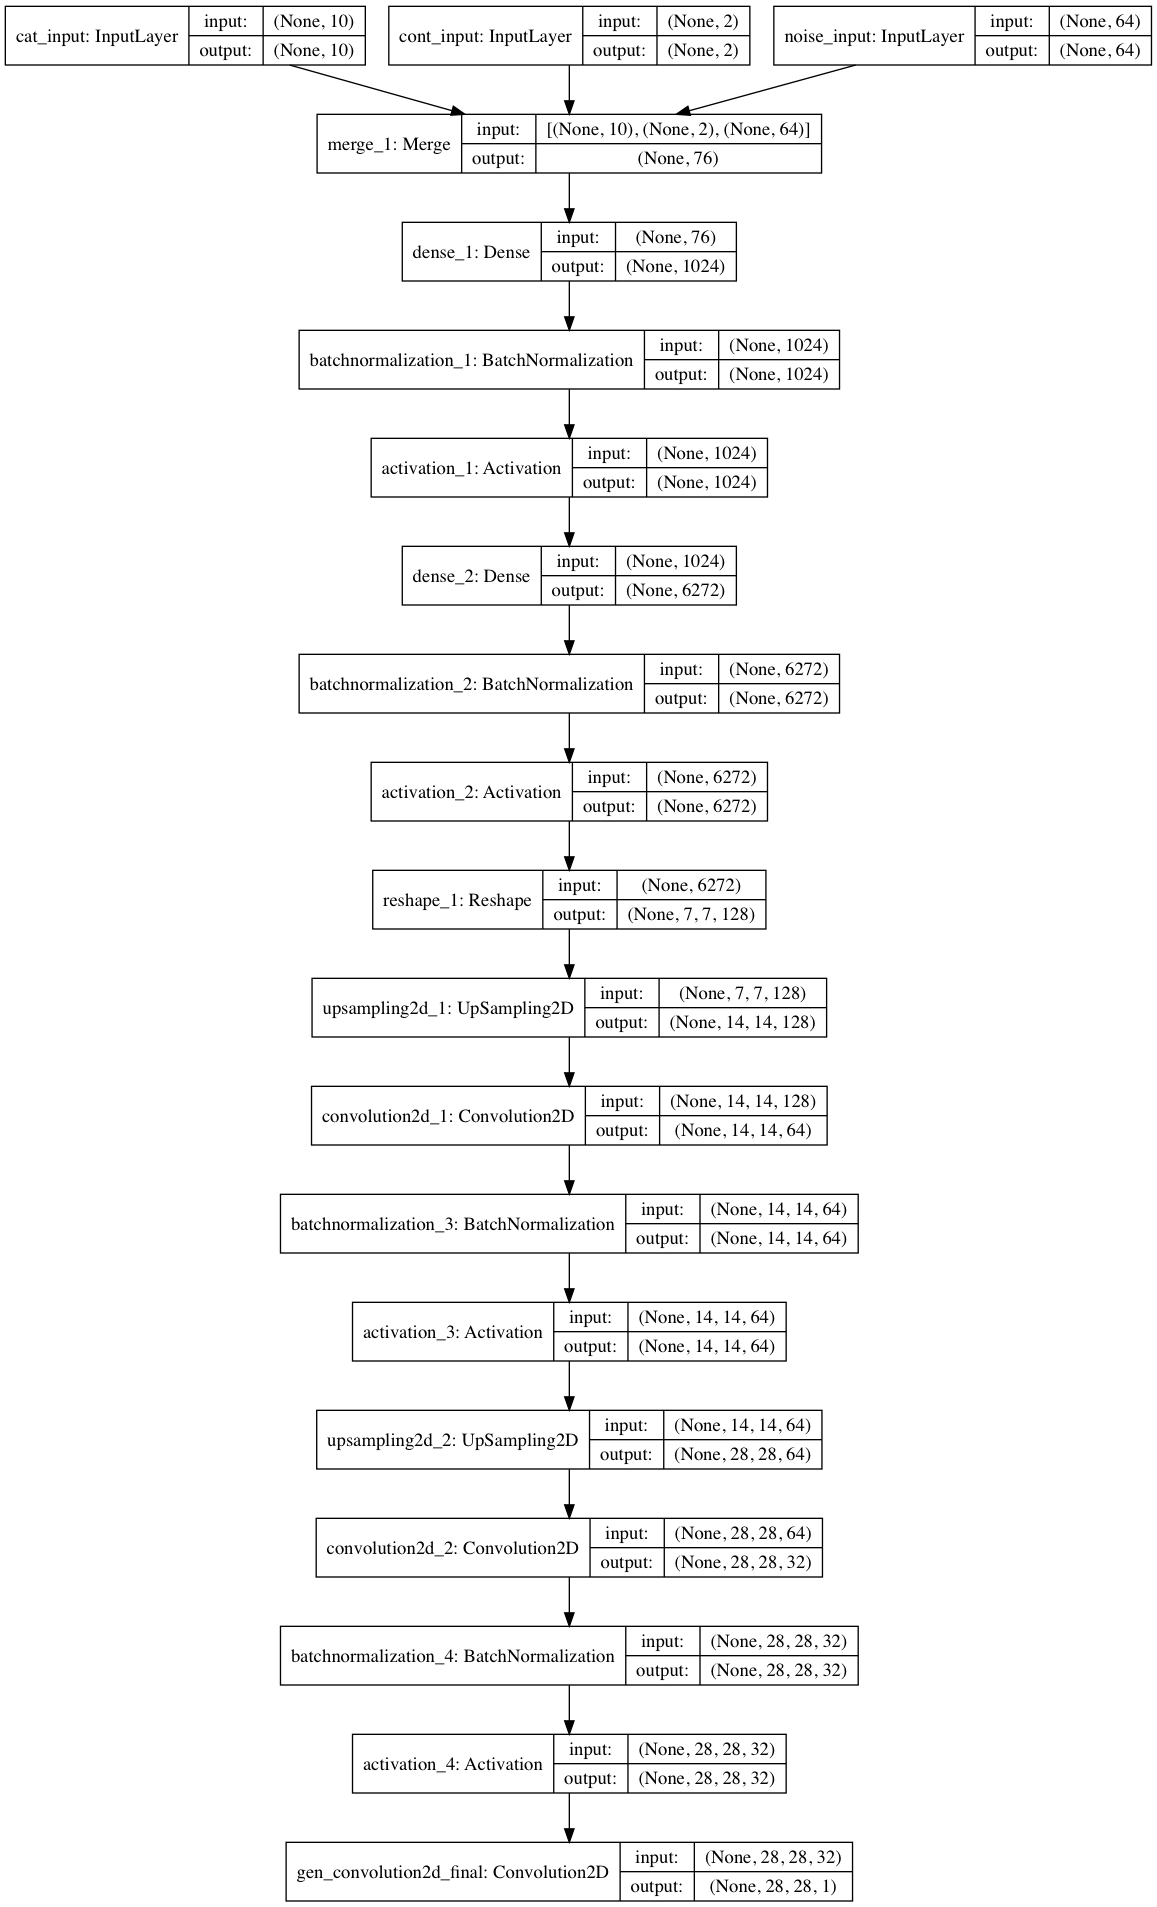

In [18]:
from keras.utils.visualize_util import plot
plot(generator_model, to_file="fig/infogan_G.png", show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image("fig/infogan_G.png")#, width=500)

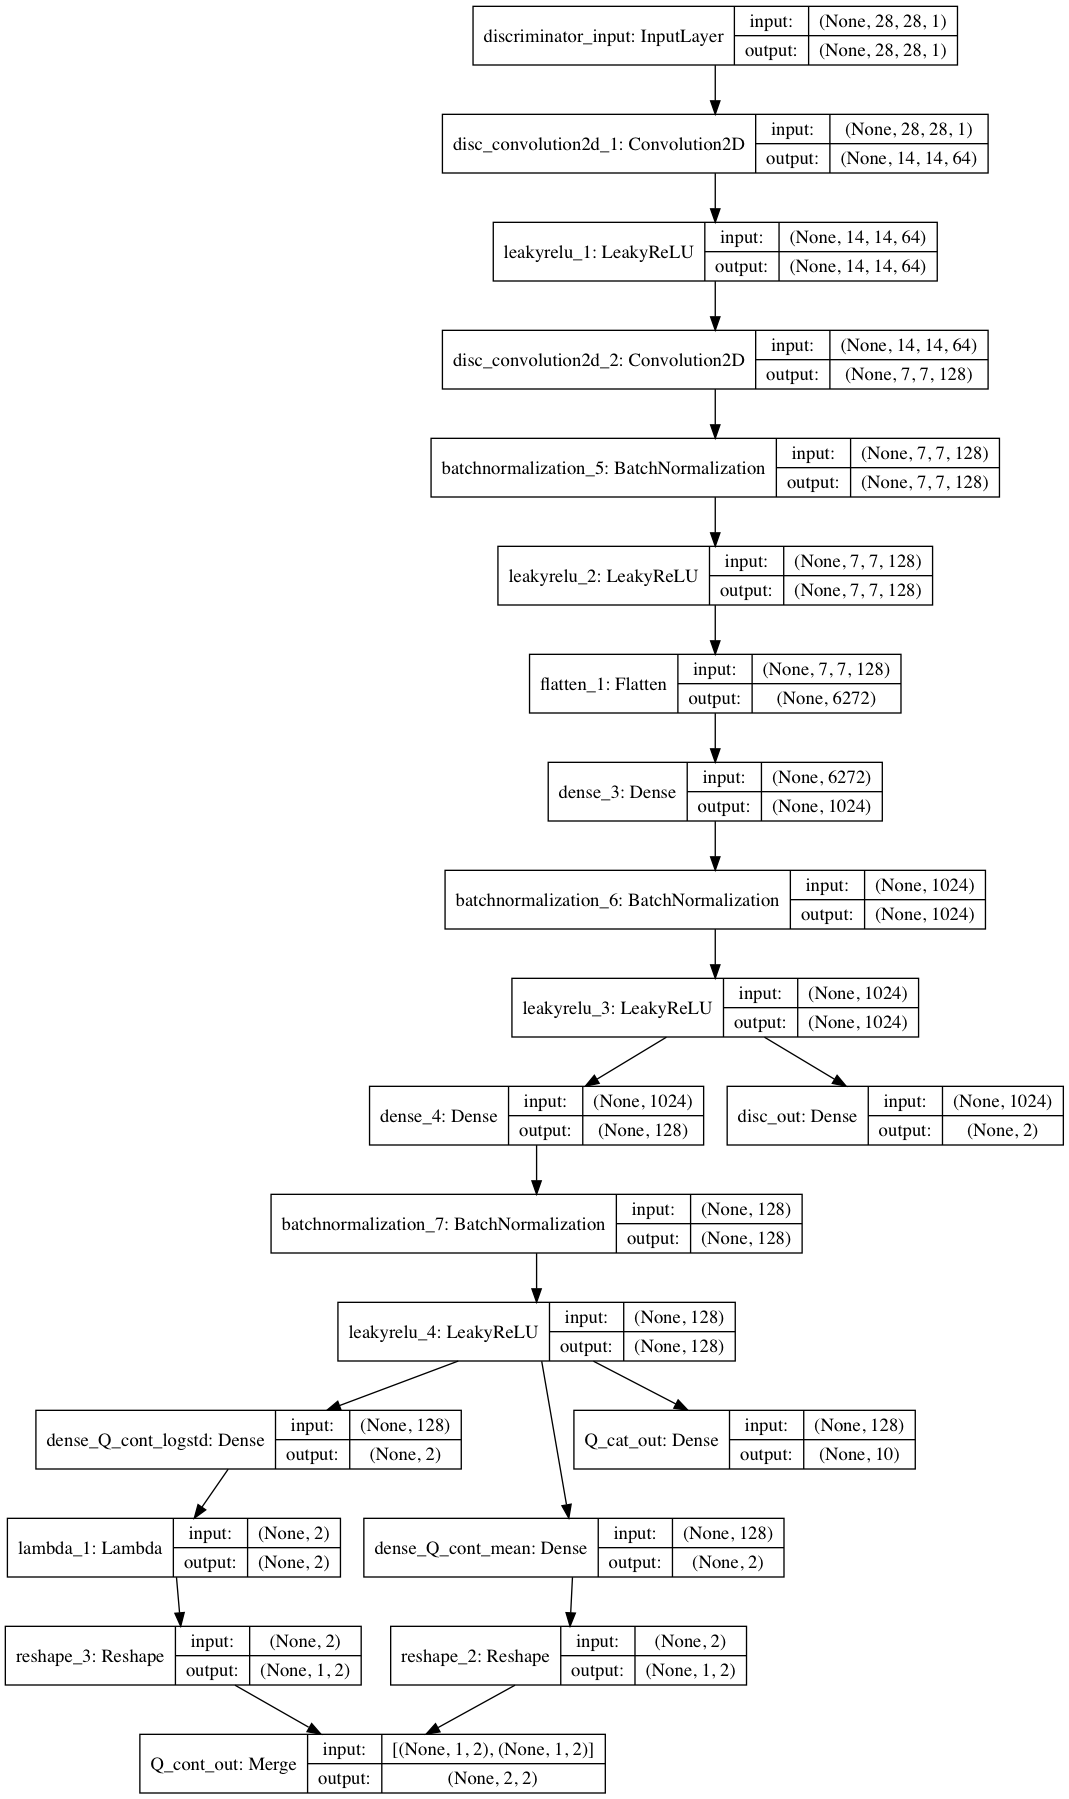

In [19]:
from keras.utils.visualize_util import plot
plot(discriminator_model, to_file="fig/infogan_D.png", show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image("fig/infogan_D.png")#, width=500)

In [14]:
nb_epoch = 400
n_batch_per_epoch = 2000
batch_size = 32
epoch_size = n_batch_per_epoch * batch_size

# Start training
print("Start training")
for e in range(nb_epoch):
    # Initialize progbar and batch counter
    progbar = generic_utils.Progbar(epoch_size)
    batch_counter = 1

    for X_real_batch in gen_batch(X_train, batch_size):

        # Create a batch to feed the discriminator model
        X_disc, y_disc, y_cat, y_cont = get_disc_batch(X_real_batch,
                                                      generator_model,
                                                      batch_counter,
                                                      batch_size,
                                                      cat_dim,
                                                      cont_dim,
                                                      noise_dim,
                                                      noise_scale=0.5,
                                                      label_smoothing=True)

        # Update the discriminator
        disc_loss = discriminator_model.train_on_batch(X_disc, [y_disc, y_cat, y_cont])

        # Create a batch to feed the generator model
        X_gen, y_gen, y_cat, y_cont, y_cont_target = get_gen_batch(batch_size,
                                                                  cat_dim,
                                                                  cont_dim,
                                                                  noise_dim,
                                                                  noise_scale=0.5)

        # Freeze the discriminator
        discriminator_model.trainable = False
        gen_loss = DCGAN_model.train_on_batch([y_cat, y_cont, X_gen], [y_gen, y_cat, y_cont_target])
        # Unfreeze the discriminator
        discriminator_model.trainable = True

        batch_counter += 1
        progbar.add(batch_size, values=[("D tot", disc_loss[0]),
                                        ("D log", disc_loss[1]),
                                        ("D cat", disc_loss[2]),
                                        ("D cont", disc_loss[3]),
                                        ("G tot", gen_loss[0]),
                                        ("G log", gen_loss[1]),
                                        ("G cat", gen_loss[2]),
                                        ("G cont", gen_loss[3])])

        if batch_counter >= n_batch_per_epoch:
            break


Start training
  576/64000 [..............................] - ETA: 2697s - D tot: 11.5748 - D log: 1.4288 - D cat: 2.4865 - D cont: 7.6595 - G tot: 5.4886 - G log: 2.2195 - G cat: 2.4034 - G cont: 0.8657 

KeyboardInterrupt: 